# Machine Learning the Ising Transition
### Carsten Bauer

# Introduction

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) is arguably the most famous model in (condensed matter) physics. It is described by the simple Hamiltonian

$$H = - J \sum_{\langle i,j \rangle} s_i s_j.$$

Here, the $s_i=\{-1,1\}$ are classical, binary magnetic moments (spins) sitting on a two-dimensional square lattice and the $\langle i,j \rangle$ indicates that only interactions betweens neighboring spins are taken into account. For simplicity, we will set $J=1$.

Most importantly, the Ising model shows a phase transition between a paramagnetic and a ferromagnetic phase as a function of temperature. The critical temperature $T_c$ at which this change of magnetic character occurs has been calculated exactly by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager). He found

In [1]:
const IsingTc = 1/(1/2*log(1+sqrt(2))) # Exact Onsager solution

2.269185314213022

In this tutorial we aim to reproduce this result (roughly) using a simple Neural Network. Basically, what we'll do was worth a [nature physics publication](https://www.nature.com/articles/nphys4035) not so long ago!

We will start by quickly simulating the Ising model using the Monte Carlo method to obtain representative sets of spin configurations for a bunch of temperatures. Afterwards, we **do not** take the traditional approach of inspecting the magnetization, the order parameter of the transition, and its susceptibility. Instead we use supervised learning to train a simple Neural Network to automagically learn the transition temperature.

# Monte Carlo simulation

The Monte Carlo method for the Ising model is very straightforward: take a random configuration of spins to begin with and propose individual spin flips until you fall asleep. To decide whether a spin should be flipped we use the Metropolis criterium

$$p = \min{\{1, e^{-\beta\Delta E}\}}$$

where $\Delta E = E' - E$ is the energy difference between the new (spin flipped) and the old configuration according to $H$ above and $\beta = 1/T$ is the inverse of the temperature $T$. Since $\Delta E$ only depends on the local environment of the spin to be flipped (nearest neighbors), we can evaluate it locally. Without going into details, here is a simple implementation of the Monte Carlo idea for the Ising model. It is not optimize by any means, but it will serve its purpose.

In [2]:
using Printf, Dates

# functions to obtain neighbors of a given site i
up(neighs, i) = neighs[1, i]
right(neighs, i) = neighs[2, i]
down(neighs, i) = neighs[3, i]
left(neighs, i) = neighs[4, i]

function montecarlo(; L, T)
    # set parameters & initialize
    nsweeps = 10^7
    measure_rate = 5_000
    beta = 1/T
    conf = rand([-1, 1], L, L)
    confs = Matrix{Int64}[] # storing intermediate configurations
    # build nearest neighbor lookup table
    lattice = reshape(1:L^2, (L, L))
    ups     = circshift(lattice, (-1,0))
    rights  = circshift(lattice, (0,-1))
    downs   = circshift(lattice,(1,0))
    lefts   = circshift(lattice,(0,1))
    neighs = vcat(ups[:]',rights[:]',downs[:]',lefts[:]')
    
    start_time = now()
    println("Started: ", Dates.format(start_time, "d.u yyyy HH:MM"))
    
    # walk over the lattice and propose to flip each spin `nsweeps` times
    for i in 1:nsweeps
        # sweep
        for i in eachindex(conf)
            # calculate ΔE
            ΔE = 2.0 * conf[i] * (conf[up(neighs, i)] + conf[right(neighs, i)] +
                                + conf[down(neighs, i)] + conf[left(neighs, i)])
            # Metropolis criterium
            if ΔE <= 0 || rand() < exp(- beta*ΔE)
                conf[i] *= -1 # flip spin
            end
        end
        
        # store the spin configuration
        iszero(mod(i, measure_rate)) && push!(confs, copy(conf))
    end
    
    end_time = now()
    println("Ended: ", Dates.format(end_time, "d.u yyyy HH:MM"))
    @printf("Duration: %.2f minutes", (end_time - start_time).value / 1000. /60.)
    
    # return the recorded spin configurations
    return confs
end

montecarlo (generic function with 1 method)

When we run this code for a small system with $L=8$ ($L$ is the linear dimension of a square lattice of size $L \times L$), we obtain 2000 (approximately) representative spin configurations.

In [3]:
montecarlo(L=8, T=5)

Started: 9.Mar 2021 11:02
Ended: 9.Mar 2021 11:02
Duration: 0.25 minutes

2000-element Array{Array{Int64,2},1}:
 [-1 1 … 1 1; -1 -1 … -1 -1; … ; 1 1 … 1 1; 1 1 … 1 -1]
 [-1 -1 … -1 -1; -1 1 … 1 -1; … ; -1 -1 … -1 -1; -1 -1 … -1 -1]
 [1 1 … -1 -1; 1 1 … 1 1; … ; 1 1 … -1 -1; 1 1 … 1 1]
 [-1 1 … 1 1; -1 1 … 1 -1; … ; -1 1 … 1 -1; -1 -1 … 1 1]
 [1 1 … 1 1; 1 1 … 1 1; … ; 1 -1 … 1 -1; -1 1 … 1 -1]
 [1 -1 … -1 -1; -1 1 … 1 1; … ; 1 1 … -1 -1; 1 -1 … -1 1]
 [1 1 … 1 -1; 1 1 … 1 1; … ; 1 1 … 1 -1; 1 1 … 1 -1]
 [-1 1 … 1 -1; -1 -1 … 1 -1; … ; -1 1 … -1 -1; 1 1 … 1 1]
 [1 1 … -1 -1; -1 1 … 1 1; … ; -1 -1 … 1 1; -1 1 … -1 1]
 [1 1 … -1 1; -1 -1 … -1 -1; … ; -1 -1 … 1 -1; -1 -1 … -1 -1]
 [-1 1 … -1 -1; 1 1 … -1 1; … ; -1 1 … -1 -1; 1 1 … 1 -1]
 [-1 1 … -1 -1; -1 1 … -1 -1; … ; -1 1 … -1 -1; -1 1 … -1 -1]
 [1 1 … -1 -1; -1 1 … 1 -1; … ; 1 1 … -1 -1; 1 1 … -1 -1]
 ⋮
 [-1 1 … -1 -1; 1 1 … -1 1; … ; 1 1 … 1 1; -1 1 … -1 -1]
 [1 -1 … 1 1; 1 -1 … 1 -1; … ; 1 1 … -1 1; -1 -1 … 1 1]
 [1 1 … -1 -1; 1 1 … 1 -1; … ; -1 1 … -1 -1; 1 1 … 1 1]
 [-1 1 … -1 1; 1 1 … 1 1; … ; 1 1 … -1 

### Simulate an $L=8$ system at a couple of temperatures

Of course, to identify the ferromagnetic phase transition as a function of temperature, we'll need at least a few more temperatures. For example, let's look at these temperatures.

In [4]:
Ts = [1.189, 1.733, 2.069, 2.269, 2.278, 2.469, 2.822, 3.367]

8-element Array{Float64,1}:
 1.189
 1.733
 2.069
 2.269
 2.278
 2.469
 2.822
 3.367

This set contains the exact Onsager solution `IsingTc` and a bunch of temperature around it as shown here:

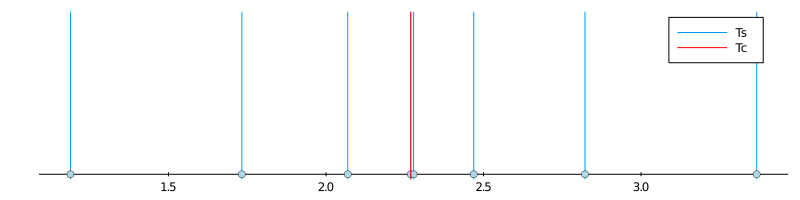

In [5]:
# visualize temperatures
using Plots
vline(Ts, grid=false, axis=:x, framestyle=:origin, xlim=(minimum(Ts)-0.1, maximum(Ts)+0.1), size=(800,200), label="Ts")
scatter!(Ts, fill(0, length(Ts)), color=:lightblue, label="")
vline!([IsingTc], color=:red, label="Tc")

Alright, now that we are prepared let's run those simulations (takes about 4 minutes on my i5 desktop machine) and store the configurations in a `T=>confs` dictionary.

In [6]:
confs = Dict{Float64, Array{Float64,3}}() # key: T, value: confs
for T in Ts
    println("T = $T"); flush(stdout);
    c = montecarlo(L=8, T=T)
    confs[T] = cat(c..., dims=3)
    println("Done.\n")
end

T = 1.189
Started: 9.Mar 2021 11:02
Ended: 9.Mar 2021 11:03
Duration: 0.27 minutesDone.

T = 1.733
Started: 9.Mar 2021 11:03
Ended: 9.Mar 2021 11:03
Duration: 0.27 minutesDone.

T = 2.069
Started: 9.Mar 2021 11:03
Ended: 9.Mar 2021 11:03
Duration: 0.28 minutesDone.

T = 2.269
Started: 9.Mar 2021 11:03
Ended: 9.Mar 2021 11:03
Duration: 0.27 minutesDone.

T = 2.278
Started: 9.Mar 2021 11:03
Ended: 9.Mar 2021 11:04
Duration: 0.30 minutesDone.

T = 2.469
Started: 9.Mar 2021 11:04
Ended: 9.Mar 2021 11:04
Duration: 0.28 minutesDone.

T = 2.822
Started: 9.Mar 2021 11:04
Ended: 9.Mar 2021 11:04
Duration: 0.27 minutesDone.

T = 3.367
Started: 9.Mar 2021 11:04
Ended: 9.Mar 2021 11:05
Duration: 0.29 minutesDone.



# Machine learning the magnetic phase transition

How can we utilize machine learning to find $T_c$? Basically, we'll build upon a simple fact: even if we don't know the precise value of $T_c$, clearly, at high temperatures the system should be disorderd, i.e. paramagnetic, since temperature is wiggling our spins such that they cannot align. Similarly, for small $T$, where temperature fluctuations are frozen out, we should be in an ordered (ferromagnetic) phase, where the vast majority of spins points in the same direction.

Ok, but how does that help? In the spirit of supervised learning, this knowledge allows us to put phase labels on some of our configurations, namely those for the highest (`Tright = 3.367`) and lowest (`Tleft = 1.189`) values of $T$. We'll consider the following simple neural network.

![](imgs/network.png)

The **green neurons** will be our input configurations. Note that we'll linearize our two-dimensional configurations, that is we'll just throw away the dimensionality information and take them each as a big, one-dimensional vector.

The **red neurons** are the hidden neurons. We'll only have a single hidden layer of 10 neurons (only showing 5 above) which is densely connected (n-to-n) to our input neurons.

The **blue neurons** are the output neurons which will indicate the network's confidence about whether we are in the paramagnetic or ferromagnetic phase (we'll use a [softmax activation](https://en.wikipedia.org/wiki/Softmax_function) to assure that their values sum up to 1).

Our training strategy now is as follows. First, we feed the network the `Tleft` configurations and, based on our knowledge that we should be ordered at this temperature, optimize the network parameters with respect to producing a 1-0 output in favor of the ferromagnetic phase. Then, we do the same for the `Tright` configurations, where we expect to have a 0-1 prediction.

Afterwards, we fix the weights and biases of the network and ask it for every intermediate temperature: How confident are you that we are in the paramagnetic/ferromagnetic phase? The point of maximal confusion, i.e. 0.5-0.5, will be what we'll identify as $T_c$.

Let's get to it. We start by loading [Flux.jl](https://fluxml.ai/), the pure Julia machine-learning stack, and a few standard libraries.

In [7]:
using Flux
using Flux: crossentropy, onecold, onehotbatch, params, throttle, @epochs
using Statistics, Random

As mentioned above, we won't/can't feed the network two-dimensional input data but have to flatten the configurations. Also, to improve the data from our quick-and-dirty simulation above, we exploit the $Z_2$ symmetry of the Ising Hamiltonian $H$ which states that we can flip all spins collectively without changing the energy of the system ($s_i \rightarrow -s_i$). This way, we effectively double our dataset.

In [60]:
function flatten_and_Z2(confs, T)
    c = confs[T]
    cs = Float32.(reshape(c, (64,:))) # flatten space dimension
    cs = hcat(cs, -one(eltype(cs)) .* cs) # concatenate Z2 (spin flip) symmetry partners
    return cs
end

flatten_and_Z2 (generic function with 1 method)

In [61]:
L = 8
Tleft = 1.189
Tright = 3.367

confs_left = flatten_and_Z2(confs, Tleft)
confs_right = flatten_and_Z2(confs, Tright);

Since visualizations are always a good thing, let's visualize the configurations at the lowest and highest temperatures.

In [62]:
# visualize configurations
printconfs(confs) = plot([heatmap(Gray.(reshape(confs[:,i], (L,L))), ticks=false) for i in 1:100:size(confs, 2)]...)

printconfs (generic function with 1 method)

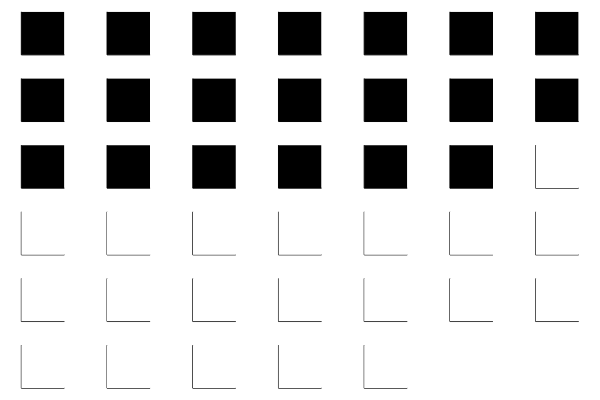

In [63]:
printconfs(confs_left)

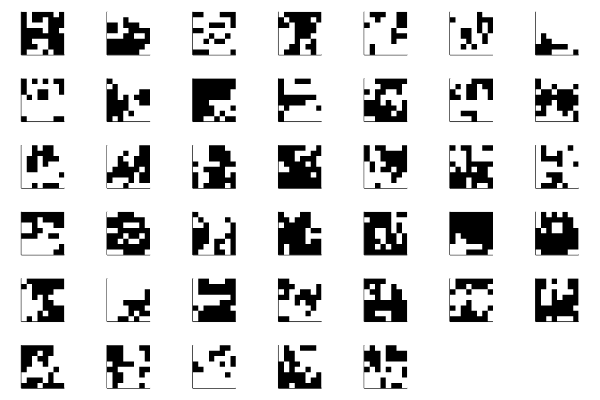

In [91]:
printconfs(confs_right)

Before we can start defining our model and training it we have to group our data into the `(X, Y)` structure that Flux expects. Once again, to fake improve our data, we repeat the data we have 10 times.

In [92]:
# set up as training data
neach = size(confs_left, 2)
X = hcat(confs_left, confs_right)
labels = vcat(fill(1, neach), fill(0, neach))
Y = onehotbatch(labels, 0:1)
dataset = Base.Iterators.repeated((X, Y), 10); # repeat dataset 10 times

Alright. So far, we have only prepared our data. Let's finally define our neural network.

In [93]:
Random.seed!(123)

m = Chain(
    Dense(L^2, 10, relu), # 10 hidden neurons
    Dense(10, 2), # two output neurons for paramagnetic vs ferromagnetic
    softmax)

Chain(Dense(64, 10, relu), Dense(10, 2), softmax)

Currently, the network parameters are random and the network has no predictive power. A good way to visualize this fact is a *confidence plot*.

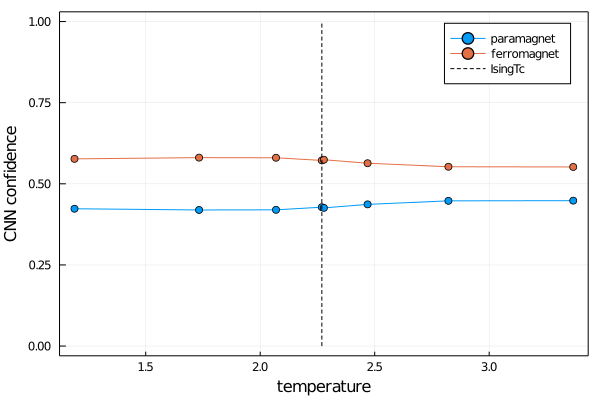

In [94]:
# classify phases at all intermediate temperatures
function confidence_plot()
    results = Dict{Float64, Vector{Float32}}()
    for T in Ts
      c = flatten_and_Z2(confs, T);
      results[T] = vec(mean(m(c), dims=2))
    end
    results = sort(results)

    p = plot(keys(results) |> collect, reduce(hcat, values(results))',
      marker=:circle,
      xlab="temperature",
      ylabel="CNN confidence",
      labels=["paramagnet" "ferromagnet"],
      frame=:box)
    plot!(p, [IsingTc, IsingTc], [0, 1], ls=:dash, color=:black, label="IsingTc")
    if (@isdefined IJulia)
        # "animation" in jupyter
        IJulia.clear_output(true)
    end
    display(p)
end

confidence_plot()

The network clearly has no idea in which phase we are. See what happens after training it for a couple of seconds.

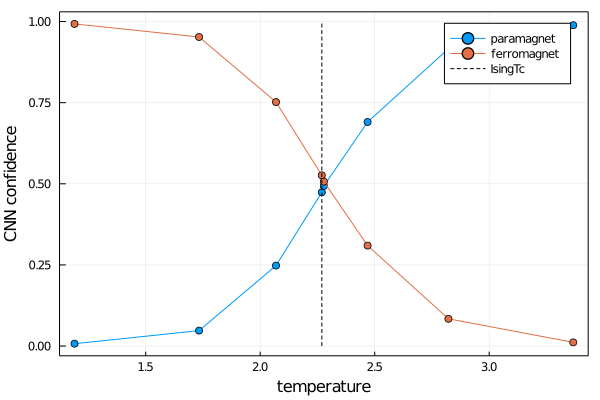

In [95]:
# define cost-function
loss(x, y) = crossentropy(m(x), y)

# define optimizer
opt = ADAM()

# train for 100 epochs
for i in 1:100
    Flux.train!(loss, params(m), dataset, opt)
end

# plot
confidence_plot()

Boom. The point of maximal confusion agrees with the exact Onsager solution remarkably well.

A couple of things have to be noted.

* The quality of the result might depend a bit on where (at which temperatures) we train the network.
* We are somewhat stretching things here as our system is tiny ($L=8$) and finite-size effects are expected. After all, the phase transition is a property of the infinite system.
* Also, our simulation was quick-and-dirty and our configurations might not be actually representitive. We'd have to use cluster updates and run simulations longer to be safe.

Despite those points, we have seen that **Monte Carlo + Machine Learning can be used to identify phase transitions** in a physical system - a new field that is interesting and exciting!

**Optional:** In Jupyter notebooks and Juno, we can visualize the learning process by updating the confidence plot during learning via a *callback* (uncomment and run the following code).

In [ ]:
# Define a callback
evalcb = () -> begin
#     @show(loss(X, Y))
#     @show(accuracy(X, Y))
    confidence_plot()
end

# Reset the network and the optimizer
Random.seed!(123)
m = Chain(
    Dense(L^2, 10, relu),
    Dense(10, 2),
    softmax)
opt = ADAM()

# Train for 100 epochs (with "animation")
for i in 1:100
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 50))
end